In [ ]:
import shutil

extraction_path = '/content/drive/MyDrive/Abdelrahman_s/new_new'

try:
    shutil.rmtree(extraction_path)  # This will delete the directory and its contents
    print(f"Deleted {extraction_path}")
except FileNotFoundError:
    print(f"{extraction_path} not found")
except PermissionError:
    print(f"Permission denied to delete {extraction_path}")
except Exception as e:
    print(f"An error occurred: {str(e)}")


/content/drive/MyDrive/Abdelrahman_s/new_new not found


In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/Abdelrahman_s/new.zip'
extraction_path = '/content/drive/MyDrive/Abdelrahman_s/new_new/images'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

ResNet:

Found 1242 validated image filenames belonging to 2 classes.


<ipython-input-12-a123dd87b351>:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gamma_corrected_images = np.array([img for img in gamma_corrected_images if img is not None])


1242/1242 [==============================] - 11s 7ms/step
Resnet Confusion Matrix (Gamma Corrected):
[[582  57]
 [ 91 512]]


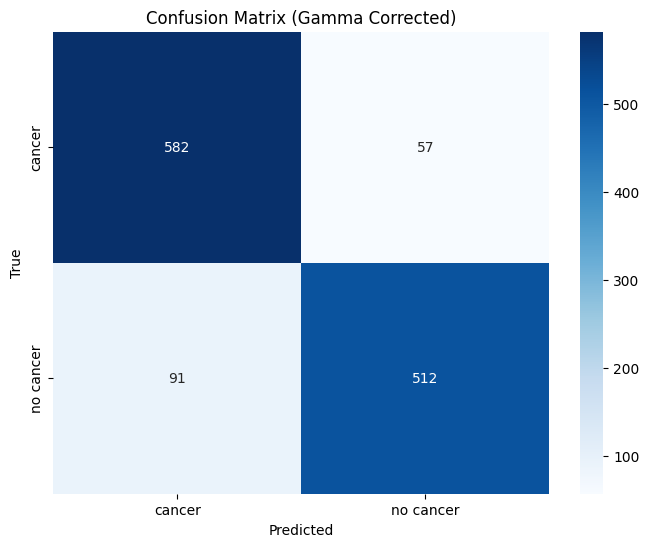


Classification Report (Gamma Corrected):
              precision    recall  f1-score   support

      cancer       0.86      0.91      0.89       639
   no cancer       0.90      0.85      0.87       603

    accuracy                           0.88      1242
   macro avg       0.88      0.88      0.88      1242
weighted avg       0.88      0.88      0.88      1242



In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool

def gamma_correction(img, gamma=1.0):
    corrected_img = np.zeros_like(img, dtype=np.float32)
    for channel in range(img.shape[2]):
        corrected_img[:, :, channel] = np.interp(img[:, :, channel], np.arange(0, 256), ((np.arange(0, 256) / 255.0) ** (1.0 / gamma)) * 255).astype(np.uint8)
    return corrected_img

test_csv_path = '/content/drive/MyDrive/Abdelrahman_s/test.csv'
image_folder = '/content/drive/MyDrive/Abdelrahman_s/new_new/images/new_new_images'
model = tf.keras.models.load_model('/content/model_checkpoint_Resnet_2_94.h5')
test_df = pd.read_csv(test_csv_path)
img_width = int(test_df['width'].values[0])
img_height = int(test_df['height'].values[0])
gamma_value = 1.5
gamma_corrected_images = []

def load_and_process_image(image_path):
    full_image_path = os.path.join(image_folder, image_path)
    if os.path.exists(full_image_path) and os.access(full_image_path, os.R_OK):
        img = tf.keras.preprocessing.image.load_img(full_image_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        gamma_corrected_img_array = gamma_correction(img_array, gamma=gamma_value)
        return gamma_corrected_img_array
    else:
        print(f"Warning: Skipped invalid or unreadable image file: {full_image_path}")
        return None
with Pool() as pool:
    gamma_corrected_images = pool.map(load_and_process_image, test_df['filename'])

gamma_corrected_images = np.array([img for img in gamma_corrected_images if img is not None])
gamma_corrected_test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
gamma_corrected_test_generator = gamma_corrected_test_generator.flow_from_dataframe(
    test_df,
    directory=image_folder,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
gamma_corrected_test_predictions = model.predict(gamma_corrected_test_generator)
y_true_gamma = gamma_corrected_test_generator.classes
y_pred_gamma = np.argmax(gamma_corrected_test_predictions, axis=1)
conf_matrix_gamma = confusion_matrix(y_true_gamma, y_pred_gamma)
print("Resnet Confusion Matrix (Gamma Corrected):")
print(conf_matrix_gamma)
class_names_gamma = gamma_corrected_test_generator.class_indices.keys()
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gamma, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_gamma, yticklabels=class_names_gamma)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Gamma Corrected)')
plt.show()
print("\nClassification Report (Gamma Corrected):")
print(classification_report(y_true_gamma, y_pred_gamma, target_names=class_names_gamma))


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
model = tf.keras.models.load_model('/content/drive/MyDrive/Abdelrahman_s/model_checkpoint_Resnet_2_94.h5')
model.summary()
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.InputLayer):
        continue
    print(layer.name, layer.activation if hasattr(layer, 'activation') else None, layer.get_config())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 35, 174, 3)]         0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 41, 180, 3)           0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 18, 87, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 18, 87, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
test_csv_path = '/content/drive/MyDrive/Abdelrahman_s/test.csv'
image_folder = '/content/drive/MyDrive/Abdelrahman_s/new_new/images/new_new_images'
model = tf.keras.models.load_model('/content/drive/MyDrive/Abdelrahman_s/final_model_VGG16_2.h5')
test_df = pd.read_csv(test_csv_path)
img_width = int(test_df['width'].values[0])
img_height = int(test_df['height'].values[0])
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
test_generator = datagen.flow_from_dataframe(
    test_df,
    directory=image_folder,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

test_predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(test_predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
print("Resnet Confusion Matrix:")
print(conf_matrix)
class_names = test_generator.class_indices.keys()
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Found 1242 validated image filenames belonging to 2 classes.
1242/1242 [==============================] - 8s 6ms/step
Resnet Confusion Matrix:
[[548  91]
 [ 85 518]]



Classification Report:
              precision    recall  f1-score   support

      cancer       0.87      0.86      0.86       639
   no cancer       0.85      0.86      0.85       603

    accuracy                           0.86      1242
   macro avg       0.86      0.86      0.86      1242
weighted avg       0.86      0.86      0.86      1242



DenseNet:

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
test_csv_path = '/content/drive/MyDrive/Abdelrahman_s/test.csv'
image_folder = '/content/drive/MyDrive/Abdelrahman_s/new_new/images/new_new_images'
model = tf.keras.models.load_model('/content/drive/MyDrive/Abdelrahman_s/final_model_DenseNet201.h5')
test_df = pd.read_csv(test_csv_path)
img_width = int(test_df['width'].values[0])
img_height = int(test_df['height'].values[0])
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
test_generator = datagen.flow_from_dataframe(
    test_df,
    directory=image_folder,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
test_predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(test_predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
print("Densenet Confusion Matrix:")
print(conf_matrix)
class_names = test_generator.class_indices.keys()
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Found 1242 validated image filenames belonging to 2 classes.
1242/1242 [==============================] - 25s 17ms/step
Densenet Confusion Matrix:
[[550  89]
 [ 71 532]]



Classification Report:
              precision    recall  f1-score   support

      cancer       0.89      0.86      0.87       639
   no cancer       0.86      0.88      0.87       603

    accuracy                           0.87      1242
   macro avg       0.87      0.87      0.87      1242
weighted avg       0.87      0.87      0.87      1242



In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
test_csv_path = '/content/drive/MyDrive/Abdelrahman_s/test.csv'
image_folder = '/content/drive/MyDrive/Abdelrahman_s/new_new/images/new_new_images'
model = tf.keras.models.load_model('/content/drive/MyDrive/Abdelrahman_s/final_model_MobileNet.h5')
test_df = pd.read_csv(test_csv_path)
img_width = int(test_df['width'].values[0])
img_height = int(test_df['height'].values[0])
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
test_generator = datagen.flow_from_dataframe(
    test_df,
    directory=image_folder,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
test_predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(test_predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
print("Resnet Confusion Matrix:")
print(conf_matrix)
class_names = test_generator.class_indices.keys()
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Found 1242 validated image filenames belonging to 2 classes.
1242/1242 [==============================] - 5s 3ms/step
Resnet Confusion Matrix:
[[389 250]
 [ 30 573]]



Classification Report:
              precision    recall  f1-score   support

      cancer       0.93      0.61      0.74       639
   no cancer       0.70      0.95      0.80       603

    accuracy                           0.77      1242
   macro avg       0.81      0.78      0.77      1242
weighted avg       0.82      0.77      0.77      1242



In [ ]:
import os
import cv2
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

# Define histogram equalization function
def apply_histogram_equalization(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

model_path = '/content/drive/MyDrive/Abdelrahman_s/Microscopic/2_checkpoint_dataset_1_final_2_F.h5'
model = load_model(model_path)
test_data_path_0 = '/content/drive/MyDrive/Abdelrahman_s/Microscopic/Fibrosarcma/Fibrosarcma/Fibrosarcma/test/0'
test_data_path_1 = '/content/drive/MyDrive/Abdelrahman_s/Microscopic/Fibrosarcma/Fibrosarcma/Fibrosarcma/test/1'

def load_data(folder_path, class_label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if os.path.isfile(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (224, 224))
                image = apply_histogram_equalization(image)
                images.append(image)
                labels.append(class_label)
    return np.array(images), np.array(labels)

X_test_0, y_test_0 = load_data(test_data_path_0, class_label=0)
X_test_1, y_test_1 = load_data(test_data_path_1, class_label=1)
X_test = np.concatenate((X_test_0, X_test_1), axis=0)
y_test = np.concatenate((y_test_0, y_test_1), axis=0)

X_features = model.predict(X_test)
X_features_pca = PCA(n_components=None).fit_transform(X_features.reshape(X_features.shape[0], -1))
clf = svm.SVC(kernel='linear', probability=True, random_state=42, verbose=True)
clf.fit(X_features_pca, y_test)
y_pred_svm = clf.predict(X_features_pca)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print("SVM Confusion Matrix:")
print(conf_matrix_svm)
class_names_svm = ['0', '1']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_svm, yticklabels=class_names_svm)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM)')
plt.show()


In [ ]:
import os
import cv2
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

def apply_histogram_equalization(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

model_path = '/content/drive/MyDrive/Abdelrahman_s/Microscopic/2_checkpoint_dataset_0_final_2_RCT.h5'
model = load_model(model_path)
test_data_path_0 = '/content/drive/MyDrive/Abdelrahman_s/Microscopic/Round_cell_tumors/Round_cell_tumors/test/0'
test_data_path_1 = '/content/drive/MyDrive/Abdelrahman_s/Microscopic/Round_cell_tumors/Round_cell_tumors/test/1'

def load_data(folder_path, class_label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if os.path.isfile(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (224, 224))
                image = apply_histogram_equalization(image)
                images.append(image)
                labels.append(class_label)
    return np.array(images), np.array(labels)

X_test_0, y_test_0 = load_data(test_data_path_0, class_label=0)
X_test_1, y_test_1 = load_data(test_data_path_1, class_label=1)
X_test = np.concatenate((X_test_0, X_test_1), axis=0)
y_test = np.concatenate((y_test_0, y_test_1), axis=0)

X_features = model.predict(X_test)
X_features_pca = PCA(n_components=None).fit_transform(X_features.reshape(X_features.shape[0], -1))
clf = svm.SVC(kernel='linear', probability=True, random_state=42, verbose=True)
clf.fit(X_features_pca, y_test)
y_pred_svm = clf.predict(X_features_pca)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print("SVM Confusion Matrix:")
print(conf_matrix_svm)
class_names_svm = ['0', '1']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_svm, yticklabels=class_names_svm)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM)')
plt.show()


In [ ]:
import os
import cv2
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
model_path = '/content/drive/MyDrive/Abdelrahman_s/Microscopic/2_checkpoint_dataset_1_final_2_F.h5'
model = load_model(model_path)
test_data_path_0 = '/content/drive/MyDrive/Abdelrahman_s/Microscopic/Fibrosarcma/Fibrosarcma/Fibrosarcma/test/0'
test_data_path_1 = '/content/drive/MyDrive/Abdelrahman_s/Microscopic/Fibrosarcma/Fibrosarcma/Fibrosarcma/test/1'

def load_data(folder_path, class_label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if os.path.isfile(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (224, 224))
                images.append(image)
                labels.append(class_label)
    return np.array(images), np.array(labels)
X_test_0, y_test_0 = load_data(test_data_path_0, class_label=0)
X_test_1, y_test_1 = load_data(test_data_path_1, class_label=1)
X_test = np.concatenate((X_test_0, X_test_1), axis=0)
y_test = np.concatenate((y_test_0, y_test_1), axis=0)
X_features = model.predict(X_test)
X_features_pca = PCA(n_components=None).fit_transform(X_features.reshape(X_features.shape[0], -1))
clf = svm.SVC(kernel='linear', probability=True, random_state=42, verbose=True)
clf.fit(X_features_pca, y_test)
y_pred_svm = clf.predict(X_features_pca)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("SVM Confusion Matrix:")
print(conf_matrix_svm)
class_names_svm = ['0', '1']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_svm, yticklabels=class_names_svm)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM)')
plt.show()

In [8]:
import os
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the pre-trained model
model_path = '/content/drive/MyDrive/Abdelrahman_s/Microscopic/best_model (1)79.h5'
model = load_model(model_path)

# Load data paths and labels from CSV
data_path = '/content/drive/MyDrive/Abdelrahman_s/Microscopic/OCSS/OCSS'
csv_file_path = '/content/drive/MyDrive/Abdelrahman_s/Microscopic/OCSS/OCSS/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data/patch/patch/patch/sabpatch_parsed_test.csv'
df = pd.read_csv(csv_file_path)

# Map lesion types to numerical labels
class_mapping = {'OSCC': 0, 'Without dysplasia': 1, 'With dysplasia': 2}
df['label'] = df['lesion'].map(class_mapping)

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42) # Adjust test size as needed

# Define a function to load images
def load_data(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        image_path = os.path.join(data_path, 'NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data/patch/patch/patch/images', row['path'])
        if os.path.isfile(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (224, 224))
                images.append(image)
                labels.append(row['label'])
    return np.array(images), np.array(labels)

# Load test data
X_test, y_test = load_data(test_df)

# Extract features using the pre-trained model
X_features = model.predict(X_test)

# Perform PCA
X_features_pca = PCA(n_components=None).fit_transform(X_features.reshape(X_features.shape[0], -1))

# Initialize and train SVM classifier
clf = SVC(kernel='linear', probability=True, random_state=42, verbose=True)
clf.fit(X_features_pca, y_test)

# Predict using the trained classifier
y_pred_svm = clf.predict(X_features_pca)

# Calculate confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Remove class 1 from the confusion matrix
conf_matrix_svm_reduced = np.delete(conf_matrix_svm, 1, axis=0)
conf_matrix_svm_reduced = np.delete(conf_matrix_svm_reduced, 1, axis=1)

print("SVM Confusion Matrix")
print(conf_matrix_svm_reduced)

# Plot reduced confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm_reduced, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM) ')
plt.show()

6/6 [==============================] - 1s 99ms/step
[LibSVM]SVM Confusion Matrix
[[21 36]
 [ 5 88]]


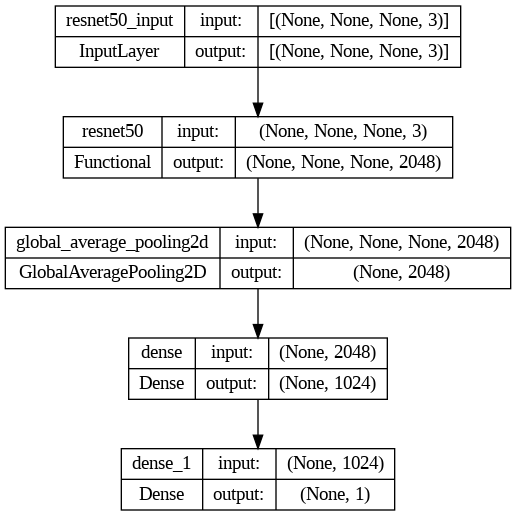

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Abdelrahman_s/Microscopic/2_checkpoint_dataset_0_final_2_RCT.h5')

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


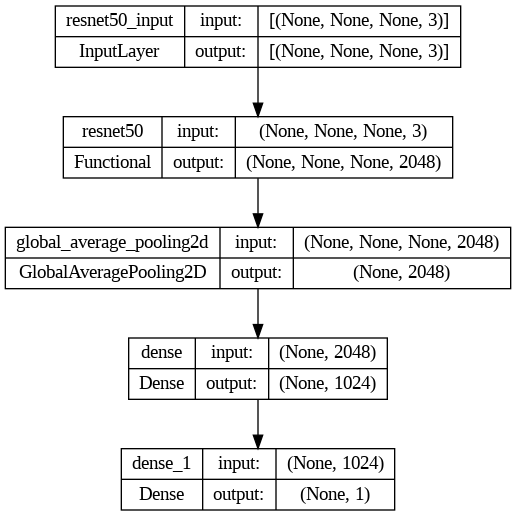

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Abdelrahman_s/Microscopic/2_checkpoint_dataset_1_final_2_F.h5')
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


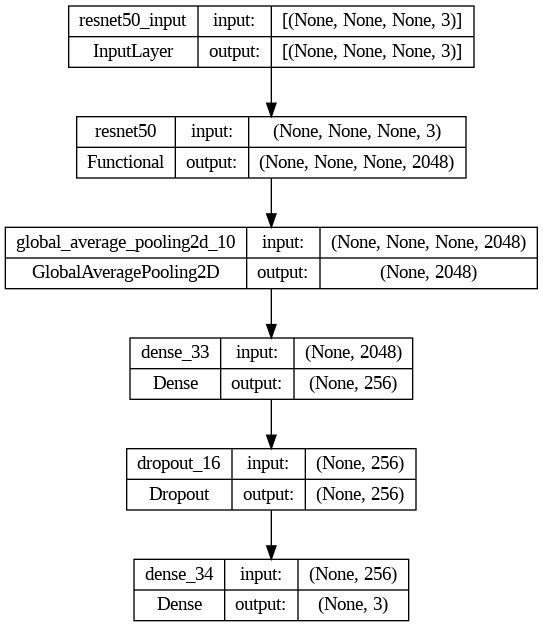

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Abdelrahman_s/Microscopic/best_model_OSCC_73.h5')
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Abdelrahman_s/model_checkpoint_Resnet_2_94.h5')
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Output hidden; open in https://colab.research.google.com to view.